# Mutual Information Metric

The `MutualInformationImageToImageMetric` class computes the mutual information between two images, i.e. the degree to which information content in one image is dependent on the other image. This example shows how `MutualInformationImageToImageMetric` can be used to map affine transformation parameters and register two images using a gradient ascent algorithm.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from urllib.request import urlretrieve

import itk
from itkwidgets import view

### Retrieve fixed and moving images for registration

We aim to register two slice images, one of which has an arbitrary offset and rotation. We seek to use an affine transform to appropriately rotate and translate the moving image to register with the fixed image.

In [2]:
fixed_image_path = "fixed.png"
moving_image_path = "moving.png"

In [3]:
if not os.path.exists(fixed_image_path):
    url = "https://data.kitware.com/api/v1/file/602c10a22fa25629b97d2896/download"
    urlretrieve(url, fixed_image_path)
if not os.path.exists(moving_image_path):
    url = "https://data.kitware.com/api/v1/file/602c10a32fa25629b97d28a0/download"
    urlretrieve(url, moving_image_path)

In [5]:
fixed_image = itk.imread(fixed_image_path, itk.F)
moving_image = itk.imread(moving_image_path, itk.F)


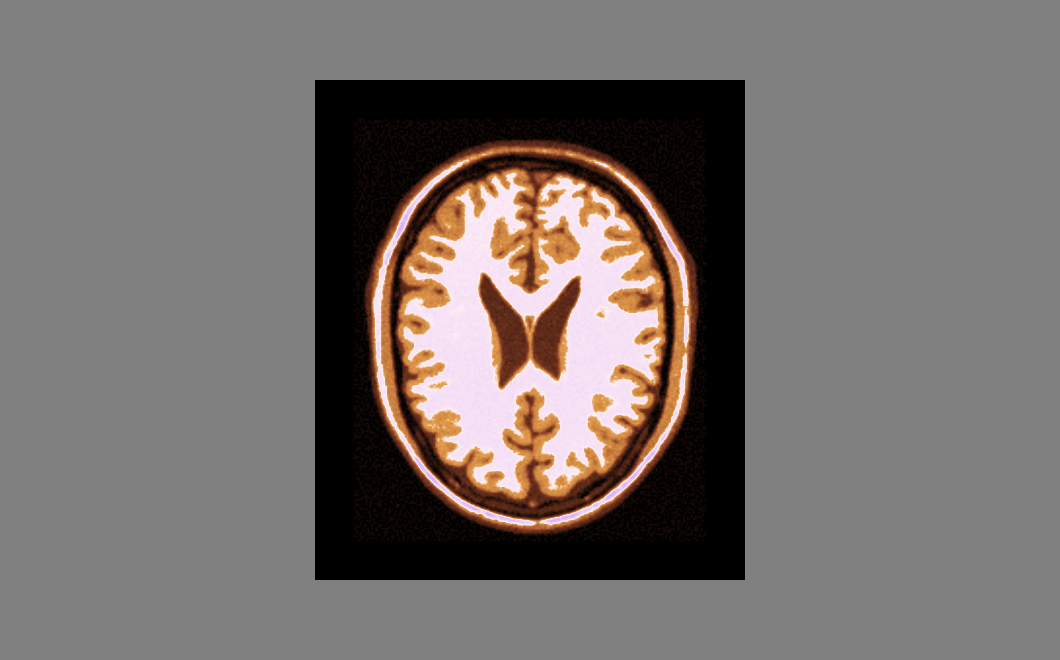
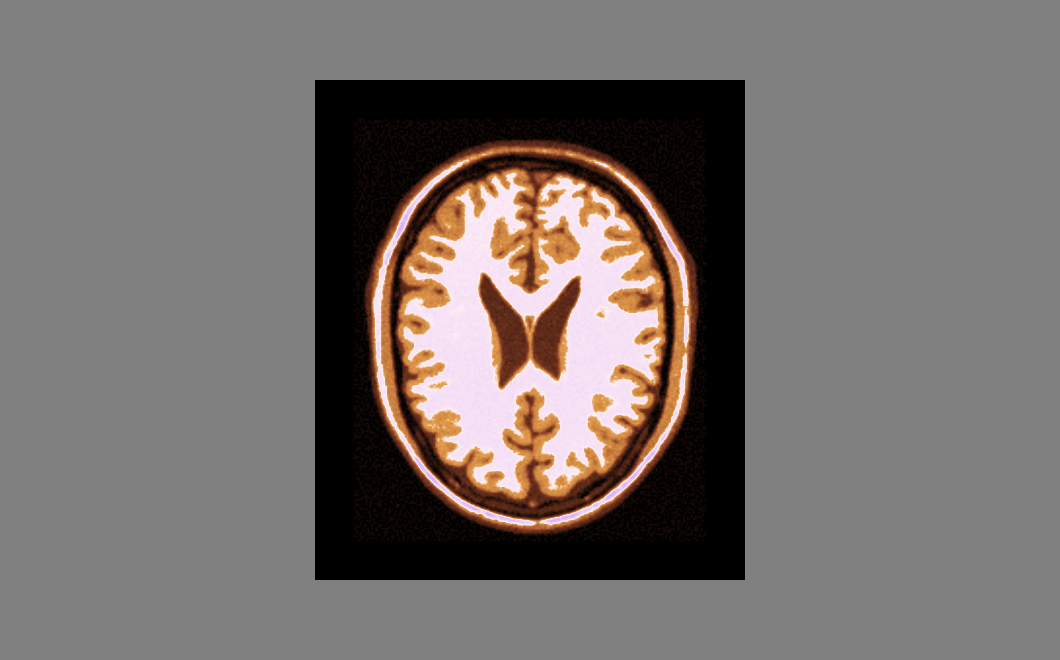

<IPython.core.display.Javascript object>

In [6]:
view(fixed_image)


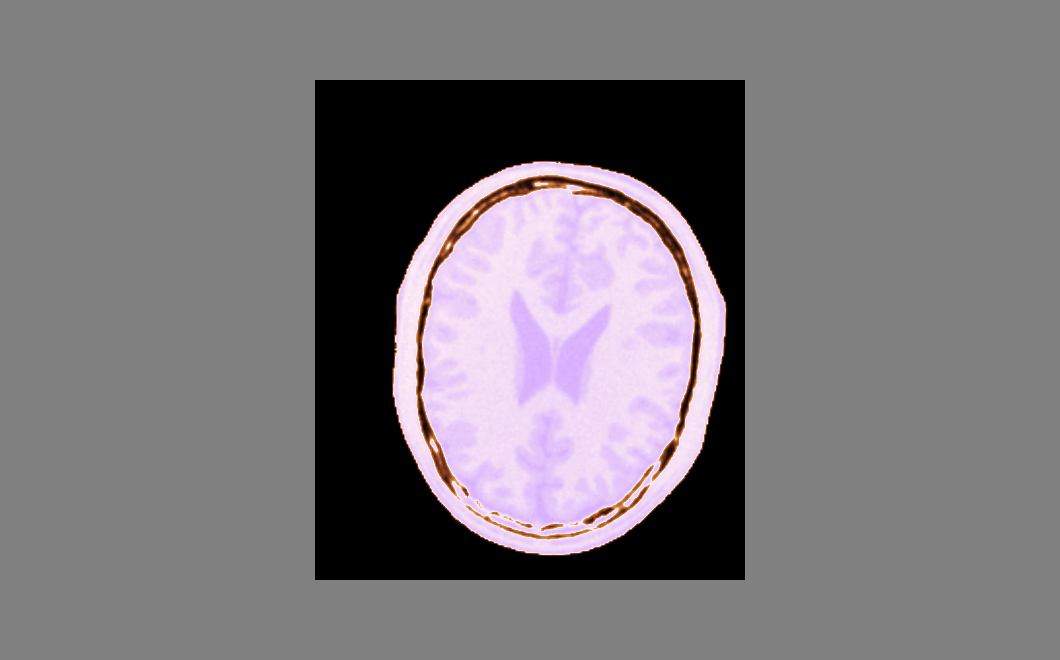
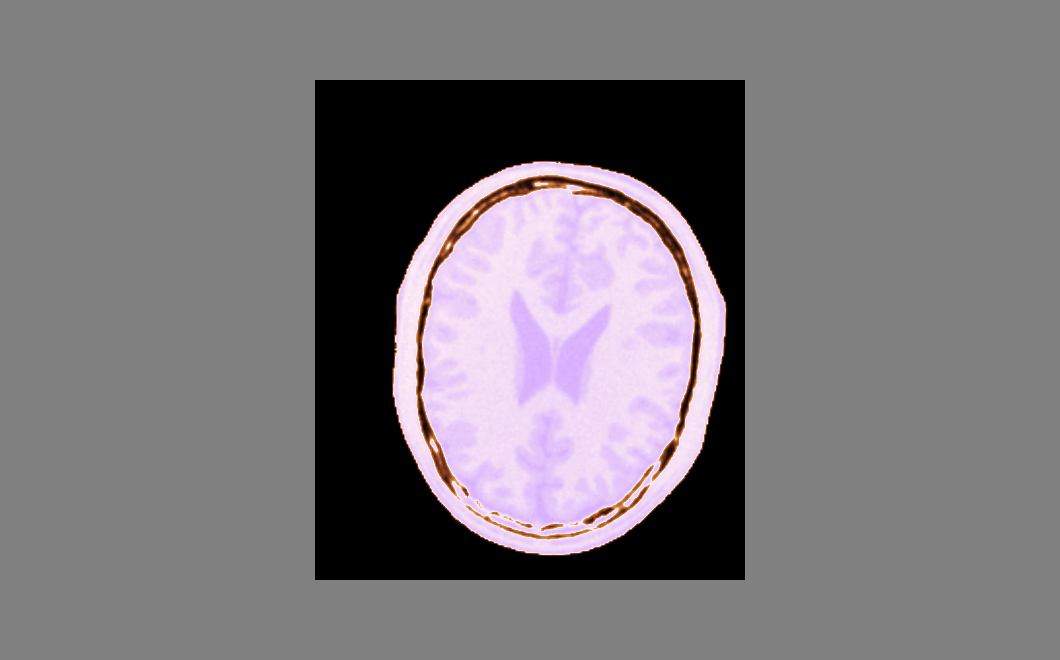

<IPython.core.display.Javascript object>

In [7]:
view(moving_image)

### Prepare images for registration

In [8]:
ImageType = type(fixed_image)

In [9]:
fixed_normalized_image = itk.normalize_image_filter(fixed_image)
fixed_smoothed_image = itk.discrete_gaussian_image_filter(fixed_normalized_image, variance=2.0)

moving_normalized_image = itk.normalize_image_filter(moving_image)
moving_smoothed_image = itk.discrete_gaussian_image_filter(moving_normalized_image, variance=2.0)


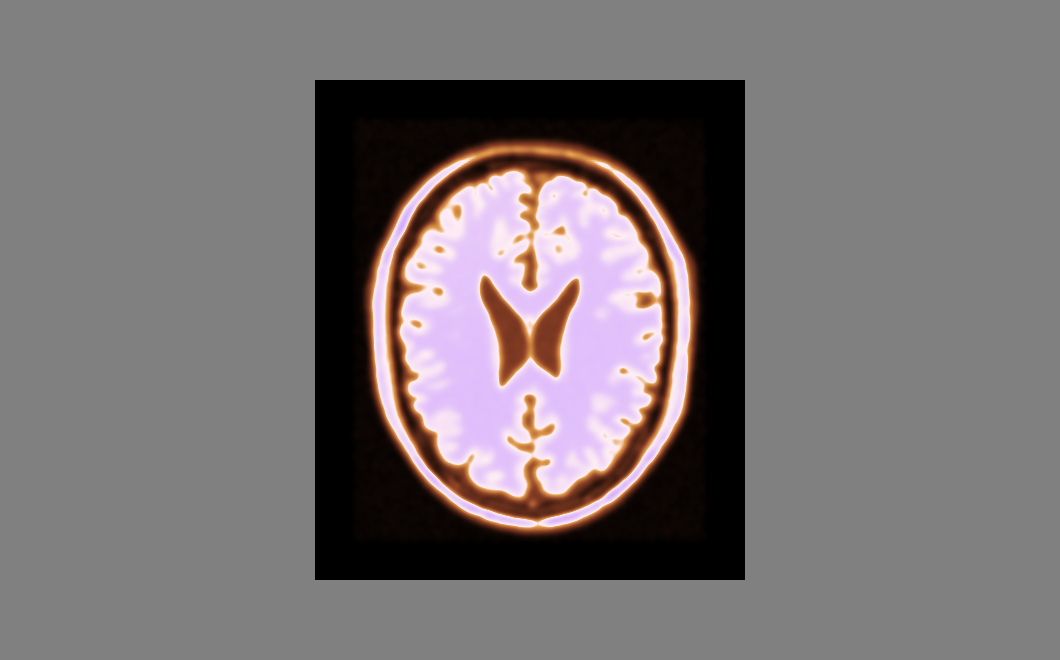
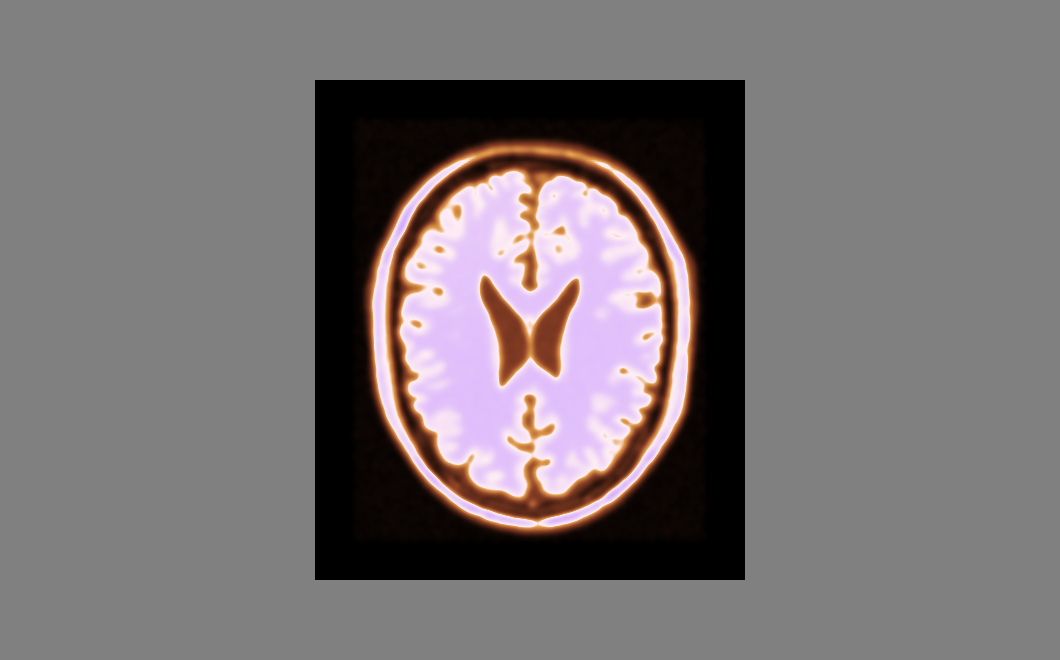

<IPython.core.display.Javascript object>

In [10]:
view(fixed_smoothed_image)

## Plot the `MutualInformationImageToImageMetric` surface

For this relatively simple example we seek to adjust only the x- and y-offset of the moving image with a `TranslationTransform`. We can acquire `MutualInformationImageToImageMetric` values comparing the two images at many different possible offset pairs with `ExhaustiveOptimizer` and visualize this data set as a surface with `matplotlib`.

The affine transform contains six parameters representing each element in an affine matrix `A` which will dictate how the moving image is sampled. We know that the moving image has been translated so we will visualize the two translation parameters, but we could set `X_INDEX` and `Y_INDEX` to visualize any pair of parameters. See [https://en.wikipedia.org/wiki/Affine_transformation#Image_transformation](https://en.wikipedia.org/wiki/Affine_transformation#Image_transformation) for more information on affine transformations.

In [11]:
X_INDEX = 4  # Translation in the X direction
Y_INDEX = 5  # Translation in the Y direction

In [12]:
# Move at most 20 pixels away from the initial position
window_size = [0] * 6
window_size[X_INDEX] = 20  # Set lower if visualizing elements 0-3
window_size[Y_INDEX] = 20  # Set lower if visualizing elements 0-3

# Collect 50 steps of data along each axis
n_steps = [0] * 6
n_steps[X_INDEX] = 50
n_steps[Y_INDEX] = 50

In [13]:
dim = fixed_image.GetImageDimension()

TransformType = itk.AffineTransform[itk.D, dim]
transform = TransformType.New()

In [14]:
InterpolatorType = itk.LinearInterpolateImageFunction[ImageType, itk.D]
interpolator = InterpolatorType.New()

In [15]:
MetricType = itk.MutualInformationImageToImageMetric[ImageType, ImageType]
metric = MetricType.New()

metric.SetNumberOfSpatialSamples(100)
metric.SetFixedImageStandardDeviation(5.0)
metric.SetMovingImageStandardDeviation(5.0)

metric.ReinitializeSeed(121212)

In [16]:
ExhaustiveOptimizerType = itk.ExhaustiveOptimizer
optimizer = ExhaustiveOptimizerType.New()

# Map out [n_steps] in each direction
optimizer.SetNumberOfSteps(n_steps)

# Move [window_size / n_steps] units with every step
scales = optimizer.GetScales()
scales.SetSize(6)

for i in range(0, 6):
    scales.SetElement(i, (window_size[i] / n_steps[i]) if n_steps[i] != 0 else 1)

optimizer.SetScales(scales)

In [17]:
# Collect data describing the parametric surface with an observer
surface = dict()


def print_iteration():
    surface[tuple(optimizer.GetCurrentPosition())] = optimizer.GetCurrentValue()


optimizer.AddObserver(itk.IterationEvent(), print_iteration)

0

In [18]:
RegistrationType = itk.ImageRegistrationMethod[ImageType, ImageType]
registrar = RegistrationType.New()

registrar.SetFixedImage(fixed_smoothed_image)
registrar.SetMovingImage(moving_smoothed_image)
registrar.SetOptimizer(optimizer)
registrar.SetTransform(transform)
registrar.SetInterpolator(interpolator)
registrar.SetMetric(metric)

registrar.SetFixedImageRegion(fixed_image.GetBufferedRegion())
registrar.SetInitialTransformParameters(transform.GetParameters())

In [19]:
registrar.Update()

In [20]:
# Check the extreme positions within the observed window
max_position = list(optimizer.GetMaximumMetricValuePosition())
min_position = list(optimizer.GetMinimumMetricValuePosition())

max_val = optimizer.GetMaximumMetricValue()
min_val = optimizer.GetMinimumMetricValue()

print(max_position)
print(min_position)

[1.0, 0.0, 0.0, 1.0, -0.4, 13.200000000000001]
[1.0, 0.0, 0.0, 1.0, -16.0, -17.6]


In [21]:
# Set up values for the plot
x_vals = [
    list(set([x[i] for x in surface.keys()])) for i in range(0, transform.GetNumberOfParameters())
]

for i in range(0, transform.GetNumberOfParameters()):
    x_vals[i].sort()

X, Y = np.meshgrid(x_vals[X_INDEX], x_vals[Y_INDEX])
Z = np.array([[surface[(1, 0, 0, 1, x0, x1)] for x1 in x_vals[X_INDEX]] for x0 in x_vals[Y_INDEX]])

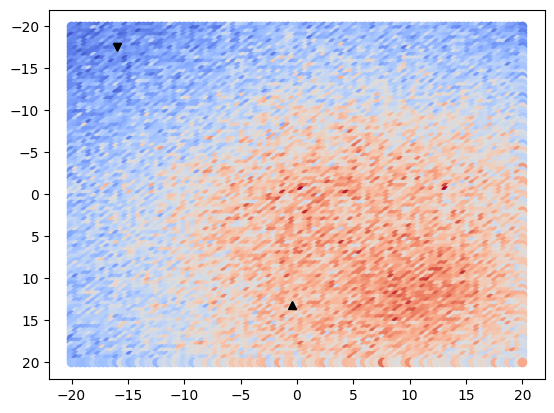

In [22]:
# Plot the surface as a 2D heat map
fig = plt.figure()

# Invert the y-axis to represent the image coordinate system
plt.gca().invert_yaxis()
ax = plt.gca()

surf = ax.scatter(X, Y, c=Z, cmap=cm.coolwarm)

# Mark extremes on the plot
ax.plot(max_position[X_INDEX], max_position[Y_INDEX], "k^")
ax.plot(min_position[X_INDEX], min_position[Y_INDEX], "kv")

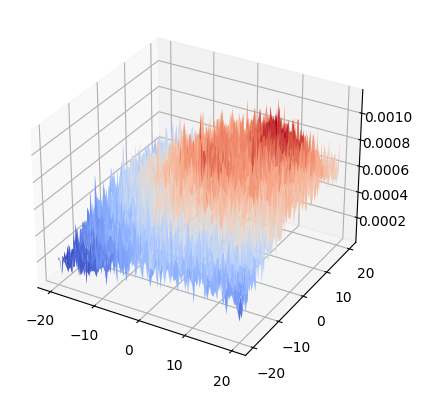

In [24]:
# Plot the surface as a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

## Follow gradient ascent

Once we understand the shape of the parametric surface it is easier to visualize the gradient ascent algorithm. We see that there is some roughness to the surface, but it has a clear slope upwards. We want to maximize the mutual information between the two images in order to optimize registration. The results of gradient ascent optimization can be superimposed onto the `matplotlib` plot.

In [25]:
transform = TransformType.New()
interpolator = InterpolatorType.New()

In [26]:
metric = MetricType.New()

metric.SetNumberOfSpatialSamples(100)
metric.SetFixedImageStandardDeviation(5.0)
metric.SetMovingImageStandardDeviation(5.0)

metric.ReinitializeSeed(121212)

In [27]:
n_iterations = 200

optimizer = itk.GradientDescentOptimizer.New()

optimizer.SetLearningRate(1.0)
optimizer.SetNumberOfIterations(n_iterations)
optimizer.MaximizeOn()

# Set scales so that the optimizer can take
# large steps along translation parameters,
# moderate steps along rotational parameters, and
# small steps along scale parameters
optimizer.SetScales([100, 0.5, 0.5, 100, 0.0001, 0.0001])

In [28]:
descent_data = dict()
descent_data[0] = (1, 0, 0, 1, 0, 0)


def log_iteration():
    descent_data[optimizer.GetCurrentIteration() + 1] = tuple(optimizer.GetCurrentPosition())


optimizer.AddObserver(itk.IterationEvent(), log_iteration)

0

In [29]:
registrar = RegistrationType.New()
registrar.SetFixedImage(fixed_smoothed_image)
registrar.SetMovingImage(moving_smoothed_image)
registrar.SetTransform(transform)
registrar.SetInterpolator(interpolator)
registrar.SetMetric(metric)
registrar.SetOptimizer(optimizer)

registrar.SetFixedImageRegion(fixed_image.GetBufferedRegion())
registrar.SetInitialTransformParameters(transform.GetParameters())

In [30]:
registrar.Update()

In [31]:
print(f"Its: {optimizer.GetCurrentIteration()}")
print(f"Final Value: {optimizer.GetValue()}")
print(f"Final Position: {list(registrar.GetLastTransformParameters())}")

Its: 200
Final Value: 0.0007345867979511311
Final Position: [1.0029839517261592, -0.010245644582257227, -0.016416327002220565, 1.0032415646265085, 13.106555670896517, 12.761316915069711]


In [32]:
descent_data

{0: (1, 0, 0, 1, 0, 0),
 1: (0.999999965527849,
  -0.001662937545476549,
  -0.0019468854493280953,
  1.0000030221155434,
  0.007072472833306728,
  -0.03606097600487629),
 2: (1.0000158649938202,
  0.001787501224727389,
  0.0014649178874578798,
  1.000018244613104,
  0.16180008682720404,
  0.11360707328765132),
 3: (1.0000425997042064,
  0.003207742575580423,
  -0.002184130940541419,
  1.0000041473195547,
  0.22605434788625897,
  0.0009694550761078363),
 4: (1.0000753342618283,
  0.0084555249529887,
  -0.00010225287048923727,
  1.0000301796832407,
  0.4832979753254417,
  0.13790535364603568),
 5: (1.0000557531623095,
  0.0016169386175090162,
  0.00013999462909987422,
  1.0000317304876585,
  0.32631462468371975,
  0.20678717167000885),
 6: (1.0000514289215043,
  0.0013991846942296745,
  0.003440991636043784,
  1.0000603451418513,
  0.2547503259637917,
  0.32331389761150536),
 7: (1.0000390671368042,
  -0.004640846244170707,
  0.0020064603033397846,
  1.0000567323503309,
  0.0867925370379

In [33]:
x_vals = [descent_data[i][X_INDEX] for i in range(0, n_iterations)]
y_vals = [descent_data[i][Y_INDEX] for i in range(0, n_iterations)]

We see in the plot that the metric generally improves as transformation parameters are updated with each iteration, but the final position may not align with the maximum position on the plot. This is one case in which it is difficult to visualize gradient ascent over a hyperdimensional space, where the optimizer is stepping through six parameter dimensions but the 2D plot we collected with `ExhaustiveOptimizer` represents a 'slice' in space with x\[0:4\] fixed at (1,0,0,1). Here it may be more useful to directly compare the two images after registration to evaluate fitness.

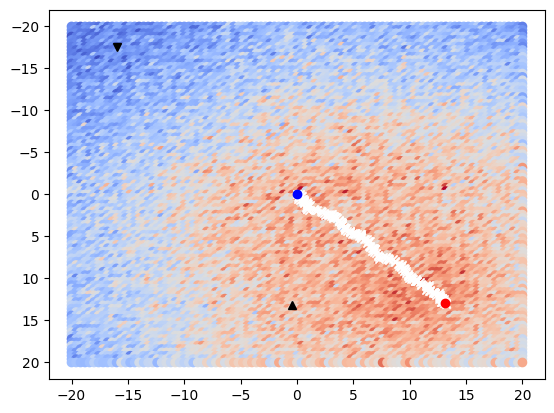

In [34]:
fig = plt.figure()
# Note: We invert the y-axis to represent the image coordinate system
plt.gca().invert_yaxis()
ax = plt.gca()

surf = ax.scatter(X, Y, c=Z, cmap=cm.coolwarm)

for i in range(0, n_iterations - 1):
    plt.plot(x_vals[i : i + 2], y_vals[i : i + 2], "wx-")
plt.plot(descent_data[0][X_INDEX], descent_data[0][Y_INDEX], "bo")
plt.plot(descent_data[n_iterations - 1][X_INDEX], descent_data[n_iterations - 1][Y_INDEX], "ro")

plt.plot(max_position[X_INDEX], max_position[Y_INDEX], "k^")
plt.plot(min_position[X_INDEX], min_position[Y_INDEX], "kv")

### Resample the moving image

In order to apply the results of gradient ascent we must resample the moving image into the domain of the fixed image. The `TranslationTransform` whose parameters have been selected through gradient ascent is used to dictate how the moving image is sampled from the fixed image domain. We can compare the two images with `itkwidgets` to verify that registration is successful.

In [35]:
ResampleFilterType = itk.ResampleImageFilter[ImageType, ImageType]
resample = ResampleFilterType.New(
    Transform=transform,
    Input=moving_image,
    Size=fixed_image.GetLargestPossibleRegion().GetSize(),
    OutputOrigin=fixed_image.GetOrigin(),
    OutputSpacing=fixed_image.GetSpacing(),
    OutputDirection=fixed_image.GetDirection(),
    DefaultPixelValue=100,
)

In [36]:
resample.Update()


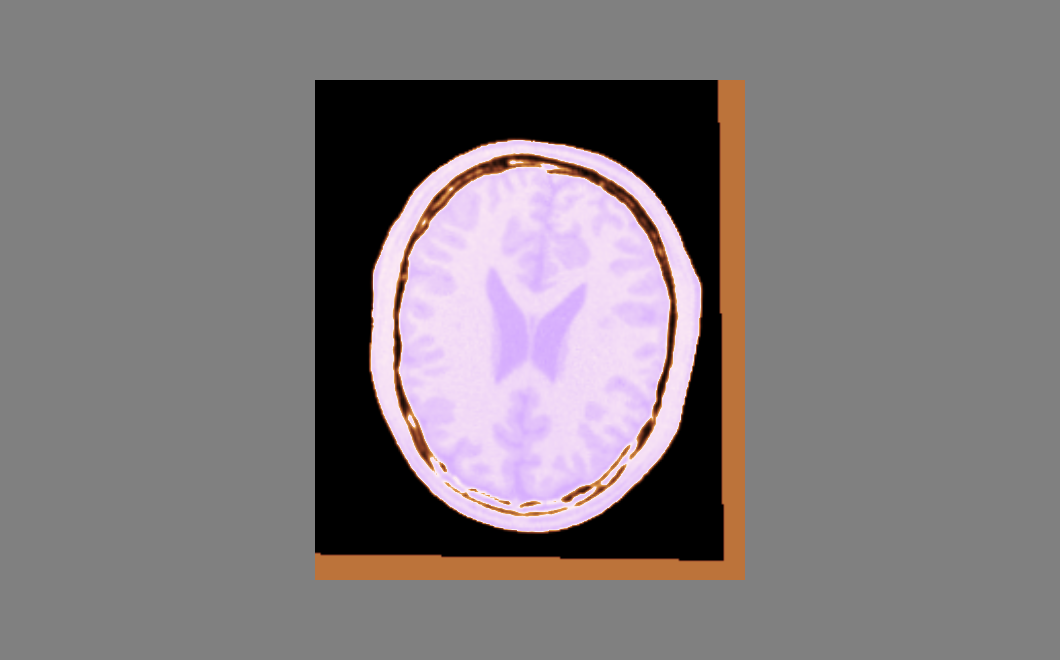
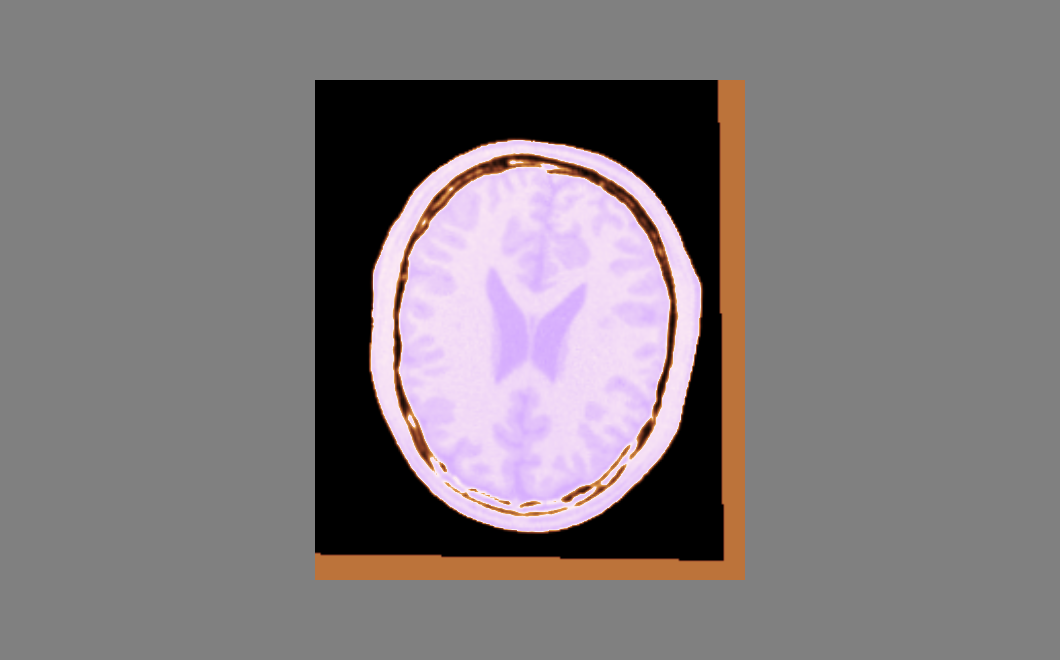

<IPython.core.display.Javascript object>

In [37]:
view(resample.GetOutput())

The image comparison shows that the images were successfully translated to overlap, but were not fully rotated to exactly align. If we were to explore further we could use a different optimizer with the metric, such as the `LBFGSBOptimizer` class, which may be more successful in optimizing over a rough parametric surface. We can also explore different metrics such as the `MattesMutualInformationImageToImageMetricv4` class to take advantage of the ITK v4+ registration framework, in contrast with the `MutualInformationImageToImageMetric` used in this example as part of the v3 framework.

### Clean up

In [38]:
os.remove(fixed_image_path)
os.remove(moving_image_path)